**Import packages**

In [1]:
!pip install pytictoc

In [2]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [3]:
(X_train, y_train), (X_test,y_test) = datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**Create helper functions**

In [4]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X)
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Plot sample image**

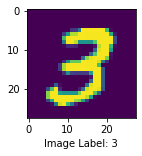

In [5]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index])

**Normalize the input data**

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

**Load the models**

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# # %cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B
# %cd /content/gdrive/MyDrive/Colab Notebooks

In [8]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST.h5')
MLP_MNIST = load_model('MLP_MNIST.h5')
CNN_MNIST = load_model('CNN_MNIST.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


# Carlini-Wagner (CW) attack


**Function for CW attack**

In [9]:
def cw_attack_NH_version(model, x, c = 0.1, max_lr = 0.1, lr_factor = 100, max_iter = 100):
  
  x = tf.convert_to_tensor(x[np.newaxis, ...])  

  y_pred_x = model(x)
  pred_class_x = np.argmax(y_pred_x)
  t = int(np.argsort(-y_pred_x, axis = 1).T[1])
  ratio = y_pred_x[0][pred_class_x]/y_pred_x[0][t]  

  delta = x * 0.001

  lr = max(max_lr,float(ratio/lr_factor));

  success_flag = 0;
  for j in range(max_iter):
    for i in range(10):
      with tf.GradientTape() as tape:
        tape.watch(delta)
        x_adv = x + delta           
        y_pred = model(x_adv)
        l2_norm = np.sqrt(np.sum((delta)**2, axis=(0,1,2)))
        F_t = y_pred[0][t]
        f_delta = l2_norm + c*max(0,0.5-F_t)        

        if np.argmax(y_pred) == t:
          break

      try:  grads = tape.gradient(f_delta, delta)
      except: continue

      delta = delta - lr * grads
          
    x_adv = np.clip(x_adv, 0, 1)    
    y_pred = model(x_adv)
    ratio = y_pred_x[0][np.argmax(y_pred_x)]/y_pred[0][t]
    delta = x_adv - x
    l2_norm = np.sqrt(np.sum((delta)**2, axis=(0,1,2)))
  
    if np.argmax(y_pred) == t:
      success_flag = 1
      break
    lr = max(max_lr,float(ratio/lr_factor));

  return success_flag, x_adv, l2_norm

In [10]:
c = 0.1; lr_factor= 100;  max_lr = 0.1; max_iter = 100

# Function for preparing CW-advarsarial examples

In [11]:
def CW_advarsarial_examples(model, X_test, c, max_lr, lr_factor, max_iter):
  
  # Create an empty numpy array to store the adversarial examples
  x_adv_stack = np.empty((0, 28, 28))

  # Loop over the test data to generate the adversarial examples and stack them in the numpy array
  for i in range(X_test.shape[0]):
      if (i+1)%500 == 0:
        print(f'First {i+1} completed')
      x = X_test[i]

      # Generate the adversarial example for the current test image
      success_flag, x_adv, l2_norm = cw_attack_NH_version(model, x, c = c, lr_factor= lr_factor, \
                                                          max_lr = max_lr, max_iter = max_iter)
      # Stack the adversarial example in the numpy array
      x_adv_stack = np.vstack((x_adv_stack, x_adv))

  return x_adv_stack

In [12]:
def correction_for_nan_entries(x_adv_stack, X_test):

  avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test)**2, axis=(1,2))))    
    
  if np.isnan(avg_l2_norm):
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        delta[indices] = 1
        x_adv_stack = X_test + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)

  return x_adv_stack

# Adversarial training of Linear model

In [ ]:
# indexes = np.arange(0,5000); c = 0.1
# X_train_CW_Linear_1 = CW_advarsarial_examples(Linear_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_Linear_1 = correction_for_nan_entries(X_train_CW_Linear_1, X_test[indexes])

# indexes = np.arange(5000,7500); c = 0.2
# X_train_CW_Linear_2 = CW_advarsarial_examples(Linear_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_Linear_2 = correction_for_nan_entries(X_train_CW_Linear_2, X_test[indexes])

# indexes = np.arange(7500,8750); c = 0.3
# X_train_CW_Linear_3 = CW_advarsarial_examples(Linear_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_Linear_3 = correction_for_nan_entries(X_train_CW_Linear_3, X_test[indexes])

# indexes = np.arange(8750, 9375); c = 0.4
# X_train_CW_Linear_4 = CW_advarsarial_examples(Linear_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_Linear_4 = correction_for_nan_entries(X_train_CW_Linear_4, X_test[indexes])

# indexes = np.arange(9375, 10000); c = 0.5
# X_train_CW_Linear_5 = CW_advarsarial_examples(Linear_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_Linear_5 = correction_for_nan_entries(X_train_CW_Linear_5, X_test[indexes])

# X_train_CW_Linear = np.concatenate((X_train_CW_Linear_1, X_train_CW_Linear_2, X_train_CW_Linear_3,\
#                                 X_train_CW_Linear_4, X_train_CW_Linear_5), axis = 0)

# indexes = range(10000)
# avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_CW_Linear-X_train[indexes])**2, axis=(1,2))))
# print("Average l2 distance of the perturbation:", avg_l2_norm)

First 500 completed
First 1000 completed
First 1500 completed
First 2000 completed
First 2500 completed
First 3000 completed
First 3500 completed
First 4000 completed
First 4500 completed
First 5000 completed
First 500 completed
First 1000 completed
First 1500 completed
First 2000 completed
First 2500 completed
First 500 completed
First 1000 completed
First 500 completed
First 500 completed
Average l2 distance of the perturbation: 10.163406947259585


In [ ]:
# X_train_stack = np.concatenate((X_train, X_train_CW_Linear), axis = 0)
# y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

# p = np.random.permutation(len(X_train_stack))
# X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

# X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

Epoch 1/50
1750/1750 [==============================] - 5s 3ms/step - loss: 1.0611 - accuracy: 0.7558 - val_loss: 0.9539 - val_accuracy: 0.7842
Epoch 2/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.9443 - accuracy: 0.7856 - val_loss: 0.9233 - val_accuracy: 0.7874
Epoch 3/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.9126 - accuracy: 0.7887 - val_loss: 0.9035 - val_accuracy: 0.7890
Epoch 4/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.8921 - accuracy: 0.7894 - val_loss: 0.8907 - val_accuracy: 0.7911
Epoch 5/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.8763 - accuracy: 0.7909 - val_loss: 0.8874 - val_accuracy: 0.7863
Epoch 6/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.8647 - accuracy: 0.7913 - val_loss: 0.8796 - val_accuracy: 0.7893
Epoch 7/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.8545 - accuracy: 0.7917 - val_loss: 0.8748 - val_accuracy:

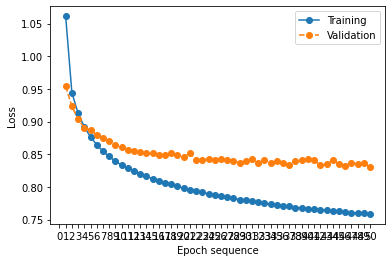

313/313 [==============================] - 1s 1ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       980
           1       0.93      0.97      0.95      1135
           2       0.94      0.87      0.91      1032
           3       0.90      0.88      0.89      1010
           4       0.89      0.94      0.91       982
           5       0.89      0.85      0.87       892
           6       0.92      0.94      0.93       958
           7       0.91      0.89      0.90      1028
           8       0.87      0.85      0.86       974
           9       0.87      0.90      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



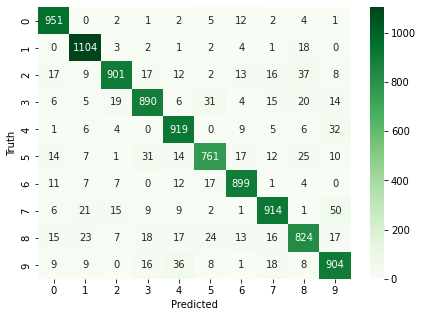

In [ ]:
# import random
# import tensorflow as tf
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)

# Linear_MNIST = models.Sequential([
#         layers.Flatten(input_shape=X_train.shape[1:]),
#         layers.Dense(10, activation='softmax'),  
#     ])

# learning_rate =  0.001
# Linear_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history_C_Linear_CW = Linear_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
#             validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

# filename = 'CW Adversarial Training history MNIST [Linear]'+'.png'
# plot_fitting_history(history_C_Linear_CW, filename, dpi = 100)

# y_pred = Linear_MNIST.predict(X_test)
# y_pred_classes = [np.argmax(element) for element in y_pred]
# classification_results(X_test,y_test,y_pred_classes)

# Linear_MNIST.save('Linear_MNIST_CW_trained.h5')

# Adversarial training of MLP model

In [ ]:
# indexes = np.arange(0,5000); c = 0.1
# X_train_CW_MLP_1 = CW_advarsarial_examples(MLP_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_MLP_1 = correction_for_nan_entries(X_train_CW_MLP_1, X_test[indexes])

# indexes = np.arange(5000,7500); c = 0.2
# X_train_CW_MLP_2 = CW_advarsarial_examples(MLP_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_MLP_2 = correction_for_nan_entries(X_train_CW_MLP_2, X_test[indexes])

# indexes = np.arange(7500,8750); c = 0.3
# X_train_CW_MLP_3 = CW_advarsarial_examples(MLP_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_MLP_3 = correction_for_nan_entries(X_train_CW_MLP_3, X_test[indexes])

# indexes = np.arange(8750, 9375); c = 0.4
# X_train_CW_MLP_4 = CW_advarsarial_examples(MLP_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_MLP_4 = correction_for_nan_entries(X_train_CW_MLP_4, X_test[indexes])

# indexes = np.arange(9375, 10000); c = 0.5
# X_train_CW_MLP_5 = CW_advarsarial_examples(MLP_MNIST, X_test[indexes], c = c, \
#                                               lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
# X_train_CW_MLP_5 = correction_for_nan_entries(X_train_CW_MLP_5, X_test[indexes])

# X_train_CW_MLP = np.concatenate((X_train_CW_MLP_1, X_train_CW_MLP_2, X_train_CW_MLP_3,\
#                                 X_train_CW_MLP_4, X_train_CW_MLP_5), axis = 0)

# indexes = range(10000)
# avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_CW_MLP-X_train[indexes])**2, axis=(1,2))))
# print("Average l2 distance of the perturbation:", avg_l2_norm)

First 500 completed
First 1000 completed
First 1500 completed
First 2000 completed
First 2500 completed
First 3000 completed
First 3500 completed
First 4000 completed
First 4500 completed
First 5000 completed
First 500 completed
First 1000 completed
First 1500 completed
First 2000 completed
First 2500 completed
First 500 completed
First 1000 completed
First 500 completed
First 500 completed
Average l2 distance of the perturbation: 12.02635653264644


In [ ]:
# X_train_stack = np.concatenate((X_train, X_train_CW_MLP), axis = 0)
# y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

# p = np.random.permutation(len(X_train_stack))
# X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

# X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

Epoch 1/50
1750/1750 [==============================] - 8s 4ms/step - loss: 0.7704 - accuracy: 0.7930 - val_loss: 0.6334 - val_accuracy: 0.8191
Epoch 2/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.5520 - accuracy: 0.8328 - val_loss: 0.5315 - val_accuracy: 0.8374
Epoch 3/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.4886 - accuracy: 0.8436 - val_loss: 0.5077 - val_accuracy: 0.8371
Epoch 4/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.4537 - accuracy: 0.8504 - val_loss: 0.4878 - val_accuracy: 0.8406
Epoch 5/50
1750/1750 [==============================] - 6s 3ms/step - loss: 0.4316 - accuracy: 0.8553 - val_loss: 0.4765 - val_accuracy: 0.8411
Epoch 6/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.4144 - accuracy: 0.8581 - val_loss: 0.4783 - val_accuracy: 0.8404
Epoch 7/50
1750/1750 [==============================] - 6s 3ms/step - loss: 0.4004 - accuracy: 0.8616 - val_loss: 0.4780 - val_accuracy:

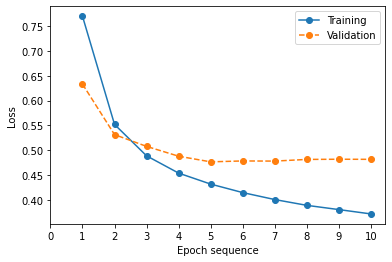

313/313 [==============================] - 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.96      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.93      0.96      0.94       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.96      0.97      0.96     10000
weighted avg       0.97      0.97      0.97     10000



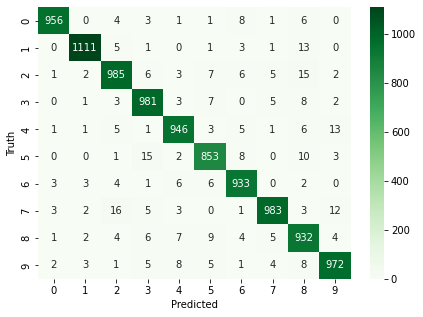

In [ ]:
# import random
# import tensorflow as tf
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)

# MLP_MNIST = models.Sequential([
#         layers.Flatten(input_shape=X_train.shape[1:]),
#         layers.Dense(2**6, activation='relu'),
#         layers.Dense(10, activation='softmax')    
#     ])

# learning_rate =  0.001
# MLP_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history_C_MLP_CW = MLP_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
#             validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

# filename = 'CW Adversarial Training history MNIST [MLP]'+'.png'
# plot_fitting_history(history_C_MLP_CW, filename, dpi = 100)

# y_pred = MLP_MNIST.predict(X_test)
# y_pred_classes = [np.argmax(element) for element in y_pred]
# classification_results(X_test,y_test,y_pred_classes)

# MLP_MNIST.save('MLP_MNIST_CW_trained.h5')

# Adversarial training of CNN model

In [16]:
indexes = np.arange(0,5000); c = 0.1
X_train_CW_CNN_1 = CW_advarsarial_examples(CNN_MNIST, X_test[indexes], c = c, \
                                              lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
X_train_CW_CNN_1 = correction_for_nan_entries(X_train_CW_CNN_1, X_test[indexes])

indexes = np.arange(5000,7500); c = 0.2
X_train_CW_CNN_2 = CW_advarsarial_examples(CNN_MNIST, X_test[indexes], c = c, \
                                              lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
X_train_CW_CNN_2 = correction_for_nan_entries(X_train_CW_CNN_2, X_test[indexes])

indexes = np.arange(7500,8750); c = 0.3
X_train_CW_CNN_3 = CW_advarsarial_examples(CNN_MNIST, X_test[indexes], c = c, \
                                              lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
X_train_CW_CNN_3 = correction_for_nan_entries(X_train_CW_CNN_3, X_test[indexes])

indexes = np.arange(8750, 9375); c = 0.4
X_train_CW_CNN_4 = CW_advarsarial_examples(CNN_MNIST, X_test[indexes], c = c, \
                                              lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
X_train_CW_CNN_4 = correction_for_nan_entries(X_train_CW_CNN_4, X_test[indexes])

indexes = np.arange(9375, 10000); c = 0.5
X_train_CW_CNN_5 = CW_advarsarial_examples(CNN_MNIST, X_test[indexes], c = c, \
                                              lr_factor= lr_factor, max_lr = max_lr, max_iter = max_iter)
X_train_CW_CNN_5 = correction_for_nan_entries(X_train_CW_CNN_5, X_test[indexes])

X_train_CW_CNN = np.concatenate((X_train_CW_CNN_1, X_train_CW_CNN_2, X_train_CW_CNN_3,\
                                X_train_CW_CNN_4, X_train_CW_CNN_5), axis = 0)

indexes = range(10000)
avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_CW_CNN-X_train[indexes])**2, axis=(1,2))))
print("Average l2 distance of the perturbation:", avg_l2_norm)

First 500 completed
First 1000 completed
First 1500 completed
First 2000 completed
First 2500 completed
First 3000 completed
First 3500 completed
First 4000 completed
First 4500 completed
First 5000 completed
First 500 completed
First 1000 completed
First 1500 completed
First 2000 completed
First 2500 completed
First 500 completed
First 1000 completed
First 500 completed
First 500 completed
Average l2 distance of the perturbation: 12.552330866440478


In [17]:
X_train_stack = np.concatenate((X_train, X_train_CW_CNN), axis = 0)
y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

p = np.random.permutation(len(X_train_stack))
X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

Epoch 1/50
1750/1750 [==============================] - 10s 4ms/step - loss: 0.7355 - accuracy: 0.7931 - val_loss: 0.5501 - val_accuracy: 0.8349
Epoch 2/50
1750/1750 [==============================] - 6s 4ms/step - loss: 0.5000 - accuracy: 0.8437 - val_loss: 0.4813 - val_accuracy: 0.8429
Epoch 3/50
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4523 - accuracy: 0.8517 - val_loss: 0.4552 - val_accuracy: 0.8465
Epoch 4/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.4284 - accuracy: 0.8545 - val_loss: 0.4541 - val_accuracy: 0.8444
Epoch 5/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.4116 - accuracy: 0.8579 - val_loss: 0.4395 - val_accuracy: 0.8464
Epoch 6/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.3992 - accuracy: 0.8601 - val_loss: 0.4279 - val_accuracy: 0.8476
Epoch 7/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.3903 - accuracy: 0.8622 - val_loss: 0.4339 - val_accuracy

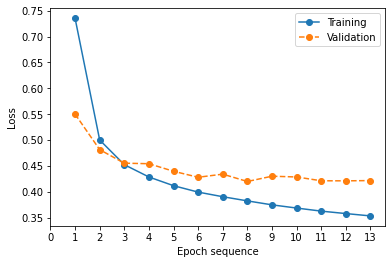

313/313 [==============================] - 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.99      0.98       958
           7       0.96      0.98      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



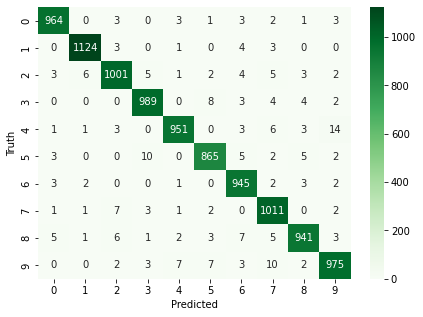

In [18]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

CNN_MNIST = models.Sequential([
    layers.Conv2D(filters=2**4, kernel_size=(3, 3), padding = 'same', 
                  activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(2**4, activation='relu'),
    layers.Dense(10, activation='softmax')
])

learning_rate =  0.001
CNN_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_CNN_CW = CNN_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

filename = 'CW Adversarial Training history MNIST [CNN]'+'.png'
plot_fitting_history(history_C_CNN_CW, filename, dpi = 100)

y_pred = CNN_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

CNN_MNIST.save('CNN_MNIST_CW_trained.h5')

# Evaluate performance of adversarial training

In [8]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST_CW_trained.h5')
MLP_MNIST = load_model('MLP_MNIST_CW_trained.h5')
CNN_MNIST = load_model('CNN_MNIST_CW_trained.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


In [9]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\CW

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\CW


# Prepare batches of adversarial examples of Linear model

**Batches of 1000 for different $c$ values**

In [11]:
model = Linear_MNIST
for c in np.arange(0.6,1.1,0.1):
    starting_point = 0;
    for lot in [0]:
      x_adv_stack_Linear_Lot = CW_advarsarial_examples(model, X_test, c = c, lr_factor= lr_factor, \
                                                                  max_lr = max_lr, max_iter = max_iter, \
                                                 starting_point = starting_point, num_samples = num_samples)
      filename = 'MNIST_x_adv_stack_Linear_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
      np.save(filename, x_adv_stack_Linear_Lot)
      starting_point = starting_point + 1000

In [ ]:
stored_results = []
lot = 0
for c in np.arange(0.1,1.1,0.1):
    filename = 'MNIST_x_adv_stack_Linear_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
    x_adv_stack = np.load(filename)
    
    stored_results.append(np.round(c,1))
    stored_results.append('Linear')
    
    avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2))))    
    
    if np.isnan(avg_l2_norm):
        # print(avg_l2_norm)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        # print(indices)
        delta[indices] = 1
        x_adv_stack = X_test[:len(x_adv_stack)] + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2))))

    
    # print(avg_l2_norm)
    stored_results.append(avg_l2_norm)
    
    _, accuracy = Linear_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = MLP_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = CNN_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,6)
df = pd.DataFrame(stored_results, columns = ['c value','Target model','avg_l2_norm','Linear_MNIST_test_accuray',\
                                              'MLP_MNIST_test_accuray','CNN_MNIST_test_accuray'])
filename = 'Post training Adversarial_Attacks_MNIST for Linear model [CW Attack].csv'
df.to_csv(filename, index=False)
df

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9720
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9720


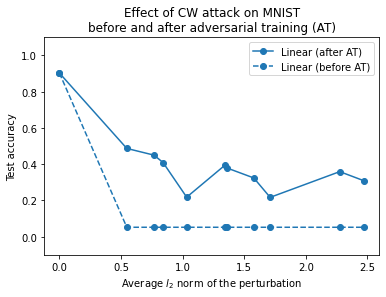

In [14]:
indexes = range(1000)
df = pd.read_csv('Post training Adversarial_Attacks_MNIST for Linear model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
# plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o-')
# plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o-')
# plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o-', color = 'C0')

df = pd.read_csv('Adversarial_Attacks_MNIST for Linear model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
# plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o--', color = 'C0')
# plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o--', color = 'C1')
# plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o--', color = 'C2')
plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o--', color = 'C0')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
# plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
#             'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.legend(['Linear (after AT)', 'Linear (before AT)'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on MNIST\nbefore and after adversarial training (AT)') #\nTraget model: Linear')
plt.savefig('Post training Effect of CW attack on MNIST for Linear model [l2 norm]_1', dpi=600)
plt.show()

# Prepare batches of adversarial examples of MLP model

**Batches of 1000 for different $c$ values**

In [ ]:
model = MLP_MNIST
for c in np.arange(0.1,1.1,0.1):
    starting_point = 0;
    for lot in [0]:
      x_adv_stack_MLP_Lot = CW_advarsarial_examples(model, X_test, c = c, lr_factor= lr_factor, \
                                                                  max_lr = max_lr, max_iter = max_iter, \
                                                 starting_point = starting_point, num_samples = num_samples)
      filename = 'MNIST_x_adv_stack_MLP_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
      np.save(filename, x_adv_stack_MLP_Lot)
      starting_point = starting_point + 1000

In [ ]:
stored_results = []
lot = 0
for c in np.arange(0.1,1.1,0.1):
    filename = 'MNIST_x_adv_stack_MLP_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
    x_adv_stack = np.load(filename)
    
    stored_results.append(np.round(c,1))
    stored_results.append('MLP')
    
    avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2))))    
    
    if np.isnan(avg_l2_norm):
        # print(avg_l2_norm)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        # print(indices)
        delta[indices] = 1
        x_adv_stack = X_test[:len(x_adv_stack)] + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2))))

    
    # print(avg_l2_norm)
    stored_results.append(avg_l2_norm)
    
    _, accuracy = Linear_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = MLP_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = CNN_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,6)
df = pd.DataFrame(stored_results, columns = ['c value','Target model','avg_l2_norm','Linear_MNIST_test_accuray',\
                                              'MLP_MNIST_test_accuray','CNN_MNIST_test_accuray'])
filename = 'Post training Adversarial_Attacks_MNIST for MLP model [CW Attack].csv'
df.to_csv(filename, index=False)
df

Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9720
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9720


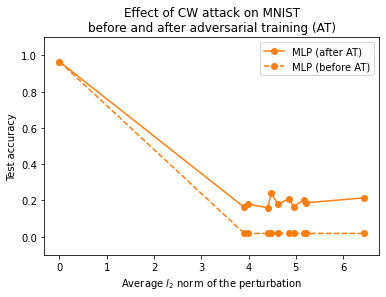

In [15]:
indexes = range(1000)
df = pd.read_csv('Post training Adversarial_Attacks_MNIST for MLP model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
# plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o-')
# plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o-')
# plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o-', color = 'C1')

df = pd.read_csv('Adversarial_Attacks_MNIST for MLP model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
# plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o--', color = 'C0')
# plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o--', color = 'C1')
# plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o--', color = 'C2')
plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o--', color = 'C1')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
# plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
#             'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.legend(['MLP (after AT)', 'MLP (before AT)'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on MNIST\nbefore and after adversarial training (AT)') #\nTraget model: MLP')
plt.savefig('Post training Effect of CW attack on MNIST for MLP model [l2 norm]_1', dpi=600)
plt.show()

# Prepare batches of adversarial examples of CNN model

In [ ]:
model = CNN_MNIST
for c in np.arange(0.1,1.1,0.1):
    starting_point = 0;
    for lot in [0]:
      x_adv_stack_CNN_Lot = CW_advarsarial_examples(model, X_test, c = c, lr_factor= lr_factor, \
                                                                  max_lr = max_lr, max_iter = max_iter, \
                                                 starting_point = starting_point, num_samples = num_samples)
      filename = 'MNIST_x_adv_stack_CNN_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
      np.save(filename, x_adv_stack_CNN_Lot)
      starting_point = starting_point + 1000

In [ ]:
stored_results = []
lot  = 0
for c in np.arange(0.1,1.1,0.1):
    filename = 'MNIST_x_adv_stack_CNN_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
    x_adv_stack = np.load(filename)
    
    stored_results.append(np.round(c,1))
    stored_results.append('CNN')
    
    avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2))))
    
    if np.isnan(avg_l2_norm):
        # print(avg_l2_norm)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        # print(indices)
        delta[indices] = 1
        x_adv_stack = X_test[:len(x_adv_stack)] + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2))))
        
    # print(avg_l2_norm)
    stored_results.append(avg_l2_norm)
    
    _, accuracy = Linear_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = MLP_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = CNN_MNIST.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,6)
df = pd.DataFrame(stored_results, columns = ['c value','Target model','avg_l2_norm','Linear_MNIST_test_accuray',\
                                              'MLP_MNIST_test_accuray','CNN_MNIST_test_accuray'])
filename = 'Post training Adversarial_Attacks_MNIST for CNN model [CW Attack].csv'
df.to_csv(filename, index=False)
df

Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9720
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9720


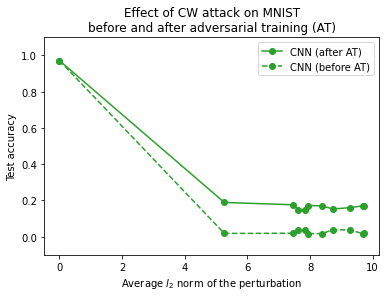

In [16]:
indexes = range(1000)
df = pd.read_csv('Post training Adversarial_Attacks_MNIST for CNN model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
# plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o-')
# plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o-')
# plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o-', color = 'C2')

df = pd.read_csv('Adversarial_Attacks_MNIST for CNN model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
# plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o--', color = 'C0')
# plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o--', color = 'C1')
# plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o--', color = 'C2')
plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
# plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
#             'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.legend(['CNN (after AT)', 'CNN (before AT)'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on MNIST\nbefore and after adversarial training (AT)') #\nTraget model: CNN')
plt.savefig('Post training Effect of CW attack on MNIST for CNN model [l2 norm]_1', dpi=600)
plt.show()

In [ ]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_MNIST.evaluate(X_test[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test[indexes],y_test[indexes])
print('\n')